In [1]:
import pandas as pd
from pandas import datetime
# Load the dataset
file_path = 'BBVA.MC.csv'
df_BBVA = pd.read_csv(file_path)

<ipython-input-1-b9507998146d>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Check for missing values
df_BBVA.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [3]:
df_BBVA = df_BBVA.interpolate(method='linear', limit_direction='both', axis=0)

In [4]:
# Convert the 'Date' column to datetime if it's not already
df_BBVA['Date'] = pd.to_datetime(df_BBVA['Date'])

# Set the 'Date' column as the index
df_BBVA.set_index('Date', inplace=True)

In [5]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Create a new dataframe with only the 'Close' column and convert it to numpy array
df_close_BBVA = df_BBVA['Close'].values.reshape(-1, 1)

# Normalize the 'OHLC_Avg' values
scaled_df_close_BBVA = scaler.fit_transform(df_close_BBVA)

In [7]:
# Define the size of the training dataset
train_size_BBVA = int(len(scaled_df_close_BBVA) * 0.8)

# Split the data into training and testing datasets
train_BBVA, test_BBVA = scaled_df_close_BBVA[0:train_size_BBVA, :], scaled_df_close_BBVA[train_size_BBVA:len(scaled_df_close_BBVA), :]

In [8]:
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create training and testing datasets
look_back = 1
trainX_BBVA, trainY_BBVA = create_dataset(train_BBVA, look_back)
testX_BBVA, testY_BBVA = create_dataset(test_BBVA, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX_BBVA, (trainX_BBVA.shape[0], 1, trainX_BBVA.shape[1]))
testX = np.reshape(testX_BBVA, (testX_BBVA.shape[0], 1, testX_BBVA.shape[1]))

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Specify the learning rate
learning_rate = 0.001

# Initialize the LSTM model
model_BBVA = Sequential()

# Add LSTM layer
model_BBVA.add(LSTM(4, input_shape=(1, look_back)))

# Add output layer
model_BBVA.add(Dense(1))

# Create an instance of the Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model_BBVA.compile(loss='mean_squared_error', optimizer=adam_optimizer)

In [10]:
# Train the model
model_BBVA.fit(trainX_BBVA, trainY_BBVA, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
2046/2046 [==============================] - 15s 3ms/step - loss: 0.0244
Epoch 2/100
2046/2046 [==============================] - 7s 3ms/step - loss: 4.1330e-04
Epoch 3/100
2046/2046 [==============================] - 6s 3ms/step - loss: 3.2663e-04
Epoch 4/100
2046/2046 [==============================] - 6s 3ms/step - loss: 2.8813e-04
Epoch 5/100
2046/2046 [==============================] - 6s 3ms/step - loss: 2.6924e-04
Epoch 6/100
2046/2046 [==============================] - 5s 3ms/step - loss: 2.6676e-04
Epoch 7/100
2046/2046 [==============================] - 7s 3ms/step - loss: 2.6475e-04
Epoch 8/100
2046/2046 [==============================] - 6s 3ms/step - loss: 2.6567e-04
Epoch 9/100
2046/2046 [==============================] - 8s 4ms/step - loss: 2.6364e-04
Epoch 10/100
2046/2046 [==============================] - 6s 3ms/step - loss: 2.6182e-04
Epoch 11/100
2046/2046 [==============================] - 7s 3ms/step - loss: 2.6859e-04
Epoch 12/100
2046/2046 [=========

In [11]:
# Evaluate the model
loss_BBVA = model_BBVA.evaluate(testX_BBVA, testY_BBVA, verbose=0)
print(f"Test Loss: {loss_BBVA}")

Test Loss: 0.00022140919463708997


In [12]:
import matplotlib.pyplot as plt

# Make predictions
testPredict_BBVA = model_BBVA.predict(testX_BBVA)

# Invert predictions back to original scale
testPredict_BBVA = scaler.inverse_transform(testPredict_BBVA)
testY_BBVA = scaler.inverse_transform([testY_BBVA])

16/16 [==============================] - 1s 5ms/step


In [13]:
from sklearn.metrics import mean_squared_error
# Flatten the arrays
testPredict_BBVA_flat = testPredict_BBVA.flatten()
testY_BBVA_flat = testY_BBVA.flatten()

# Check the shapes
print(f'Shape of testY_BBVA: {testY_BBVA_flat.shape}')
print(f'Shape of testPredict_BBVA: {testPredict_BBVA_flat.shape}')

# Ensure that the shapes are the same before calculating the metrics
if testY_BBVA_flat.shape == testPredict_BBVA_flat.shape:
    # Calculate MSE
    mse = mean_squared_error(testY_BBVA_flat, testPredict_BBVA_flat)
    print(f'Mean Squared Error (MSE): {mse}')

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Calculate MAPE
    mape = np.mean(np.abs((testY_BBVA_flat - testPredict_BBVA_flat) / testY_BBVA_flat)) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
else:
    print("Error: The shapes of testY_BBVA and testPredict_BBVA do not match.")


Shape of testY_BBVA: (510,)
Shape of testPredict_BBVA: (510,)
Mean Squared Error (MSE): 0.013353357197025281
Root Mean Squared Error (RMSE): 0.11555672718204371
Mean Absolute Percentage Error (MAPE): 1.4478472806216156%


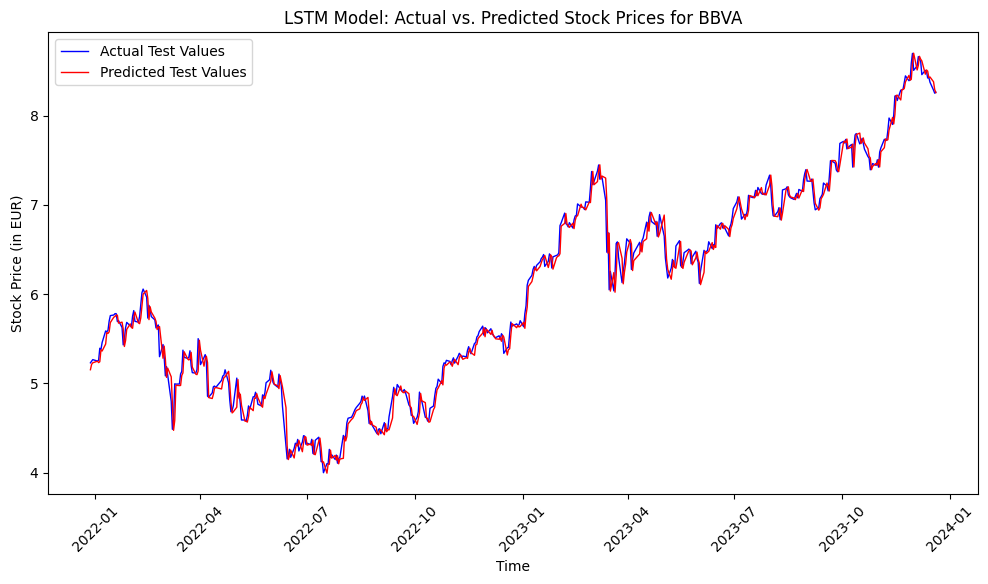

In [14]:
# Extract dates corresponding to the test data
test_dates = df_BBVA.index[train_size_BBVA + look_back + 1:len(df_BBVA)]

# Plotting the test predictions
plt.figure(figsize=(12,6))
plt.plot(test_dates, testY_BBVA_flat, label='Actual Test Values', color='blue', linewidth=1)
plt.plot(test_dates, testPredict_BBVA_flat, label='Predicted Test Values', color='red', linewidth=1)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices for BBVA')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

